# Módulo 2: HTML: Requests y BeautifulSoup
## Parsing Pagina12

<img src='https://www.pagina12.com.ar/assets/media/logos/logo_pagina_12_n.svg?v=1.0.178' width=300></img>
En este módulo veremos cómo utilizar las bibliotecas `requests` y `bs4` para programar scrapers de sitios HTML. Nos propondremos armar un scraper de noticias del diario <a href='www.pagina12.com.ar'>Página 12</a>.

Supongamos que queremos leer el diario por internet. Lo primero que hacemos es abrir el navegador, escribir la URL del diario y apretar Enter para que aparezca la página del diario. Lo que ocurre en el momento en el que apretamos Enter es lo siguiente:
1. El navegador envía una solicitud a la URL pidiéndole información.
2. El servidor recibe la petición y procesa la respuesta.
3. El servidor envía la respuesta a la IP de la cual recibió la solicitud.
4. Nuestro navegador recibe la respuesta y la muestra **formateada** en pantalla.

Para hacer un scraper debemos hacer un programa que replique este flujo de forma automática para luego extraer la información deseada de la respuesta. Utilizaremos `requests` para realizar peticiones y recibir las respuestas y `bs4` para *parsear* la respuesta y extraer la información.<br>
Te dejo unos links que tal vez te sean de utilidad:
- [Códigos de status HTTP](https://developer.mozilla.org/es/docs/Web/HTTP/Status)
- [Documentación de requests](https://requests.kennethreitz.org/en/master/)
- [Documentación de bs4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

In [ ]:
import requests

In [ ]:
url = 'https://www.pagina12.com.ar/'

In [ ]:
p12 = requests.get(url)

In [ ]:
p12.status_code

In [ ]:
p12.content

Muchas veces la respuesta a la solicitud puede ser algo que no sea un texto: una imagen, un archivo de audio, un video, etc.

In [ ]:
p12.text

Analicemos otros elementos de la respuesta

In [ ]:
p12.headers

In [ ]:
p12.request.headers

El contenido de la request que acabamos de hacer está avisando que estamos utilizando la biblioteca requests para python y que no es un navegador convencional. Se puede modificar

In [ ]:
p12.cookies

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
s = BeautifulSoup(p12.text, 'lxml')

In [ ]:
type(s)

In [ ]:
print(s.prettify())

Primer ejercicio: obtener un listado de links a las distintas secciones del diario.<br>
Usar el inspector de elementos para ver dónde se encuentra la información.

In [ ]:
s.find('ul', attrs={'class':'horizontal-list main-sections hide-on-dropdown'})

In [ ]:
secciones = s.find('ul', attrs={'class':'horizontal-list main-sections hide-on-dropdown'}).find_all('li')
secciones

## Clase 6
Vamos a empezar a extraer información contenida en los tags. A veces puede ser el texto del tag o puede ser algún atributo

In [ ]:
[seccion.text for seccion in secciones]

In [ ]:
seccion = secciones[0]
seccion

In [ ]:
seccion.a

In [ ]:
seccion.a.get_text()

In [ ]:
seccion.a.get('href') # para tomar el link 

Estamos interesados en los links, no en el texto

In [ ]:
links_secciones = [seccion.a.get('href') for seccion in secciones]
links_secciones

Carguemos la página de una sección para ver cómo se compone

In [ ]:
sec = requests.get(links_secciones[0])

In [ ]:
sec.status_code

In [ ]:
sec.request.url

In [ ]:
soup_seccion = BeautifulSoup(sec.text, 'lxml')

In [ ]:
print(soup_seccion.prettify())

La página se divide en un artículo promocionado y una lista `<ul>` con el resto de los artículos

In [ ]:
featured_article = soup_seccion.find('div', attrs={'class':'articles-list'})
featured_article

In [ ]:
featured_article.a.get('href')

In [ ]:
article_list = soup_seccion.find('article', attrs={'class':'article-item article-item--teaser'})


In [ ]:
article_list


## RETO
Armar una función que reciba la soup de una página de una sección y devuelva una lista con links a las notas de esa sección.

*Tip*: La función `find` devuelve ```None``` si no encontró el tag

In [ ]:
def obtener_notas(soup):
    '''
    Función que recibe un objeto de BeautifulSoup de una página de una sección
    y devuelve una lista de URLs a las notas de esa sección
    '''
    lista_notas = []
    
    # obtener el articulo promocional
    
    featured_articule = soup.find('div', attrs={'class':'articles-list'})
    if featured_articule:
        lista_notas.append(featured_articule.a.get('href'))
    # lista de articulos
    articule_list = soup.find('article', attrs={'class':'article-item article-item--teaser'})
    for article in article_list.find_all('h4'):
        if article.a:
            lista_notas.append(article.a.get('href'))
    
    return lista_notas
    

In [ ]:
obtener_notas(soup_seccion)

## Clase 7
En esta clase te voy a hablar un poco del manejo de errores. Para eso vamos a tomar como ejemplo uno de los links que obtuvimos con la función que tenías que armar en la clase anterior.

Código de error != 200

In [ ]:
lista_notas = obtener_notas(soup_seccion)

In [ ]:
r = requests.get(url)
r 

In [ ]:
r.status_code

In [ ]:
r = requests.get(lista_notas[0])
if r.status_code == 200:
    # Procesamos la respuesta
    print('procesamos..')
else:
     # Informar el error
    print('informamos...')

In [ ]:
url_nota = lista_notas[0]
print(url_nota)

Supongamos que el link a la nota está mal cargado, o que sacaron la nota del sitio, o que directamente no está funcionando la web de página 12

In [ ]:
url_mala = url_nota.replace('2','3')
print(url_mala)

In [ ]:
r = requests.get(url_mala)
if r.status_code == 200:
    # Procesamos la respuesta
    print('procesamos..')
else:
     # Informar el error
    print('informamos status code != 200')

Obtuvimos un error que interrumpió la ejecución del código. No llegamos a imprimir el status code. Muchas veces estos errores son inevitables y no dependen de nosotros. Lo que sí depende de nosotros es cómo procesarlos y escribir un código que sea robusto y resistente a los errores.

In [ ]:
try:
    nota = requests.get(url_mala)
except:
    print('Error en la request!\n')
    
print('El resto del programa continúa...')

In [ ]:
# Las buenas prácticas de programación incluyen el manejo de errores para darle robustez al código
try:
    nota = requests.get(url_mala)
except Exception as e:
    print('Error en la request:')
    print(e)
    print('\n')
    
print('El resto del programa continúa...')

Lo mismo ocurre cuando encadenamos búsquedas. Retomemos esta línea

In [ ]:
featured_article.a.get('href')

Si no existe el tag "a", obtendremos un error que dice que un objeto None no tiene ningún método .get('href')

In [ ]:
try:
    featured_article.b.get('href')
except:
    pass

In [ ]:
featured_article.b.get('href')

## Clase 8
En esta clase vamos a empezar a descargar el contenido de la nota. Carguémosla


In [ ]:
url_nota = lista_notas[0]
print(url_nota)

In [ ]:
try:
    nota = requests.get(url_nota)
    if nota.status_code == 200:
        s_nota = BeautifulSoup(nota.text, 'lxml')
        # Extraemos el título
        titulo = s_nota.find('h1', attrs={'class':'article-title'})
        print(titulo.text)
        # Extraemos la fecha
        fecha = s_nota.find('span', attrs={'pubdate':'pubdate'}).get('datetime')
        print(fecha)  
        # Extraemos la volanta
        volanta = s_nota.find('h2', attrs={'class':'article-prefix'}).get_text()
        print(volanta)  

        #ret_dict[] = 'volanta'
        #if volanta:
        #    ret_dict['volanta'] = volanta.get_text()
        #else:
        #    ret_dict['volanta'] = None      

except Exception as e:
    print('Error:')
    print(e)
    print('\n')

## CLASE
Vamos a extraer la imagen        
        

In [ ]:
media = s_nota.find('div', attrs={'class':'article-main-media-image'})

In [ ]:
imagenes = media.find_all('img')
imagenes

Obtuvimos varias imágenes de distintos tamaños que se mostrarán en función del tamaño de la pantalla/navegador. Vemos que están ordenadas por tamaño así que intentaremos obtener la de mayor resolución

In [ ]:
if len(imagenes) == 0:
    print('no se encontraron imágenes')
else:
    imagen = imagenes[-1] # la ultima imagen
    img_src = imagen.get('data-src')
    print(img_src)

In [ ]:
img_req = requests.get(img_src)
img_req.status_code

In [ ]:
img_req.content

In [121]:
# libreria para imagenes
from IPython.display import Image 

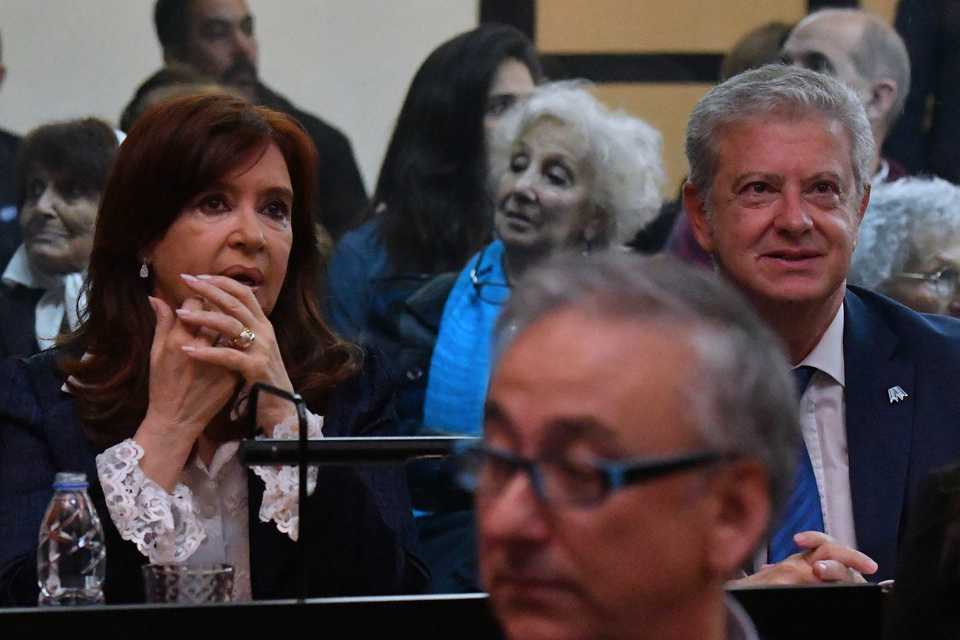

In [122]:
Image(img_req.content)